In [1]:
import numpy as np
from astropy import units as u
from astropy import time
from astropy import coordinates as c

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.twobody.propagation import propagate
from poliastro.examples import iss
import matplotlib.pyplot as plt
from poliastro import iod
from poliastro.bodies import Earth, Mars, Sun
from poliastro.ephem import Ephem
from poliastro.maneuver import Maneuver
from poliastro.twobody import Orbit
from poliastro.util import time_range
from poliastro.plotting import OrbitPlotter3D, StaticOrbitPlotter
from poliastro.earth.atmosphere import COESA76
from poliastro.twobody.propagation import cowell
from poliastro.plotting import OrbitPlotter3D
from poliastro.util import norm
import plotly.io as pio
pio.renderers.default = "notebook_connected"
from poliastro.twobody.events import LithobrakeEvent
from astropy.coordinates import SphericalRepresentation
import math as Math
from poliastro.twobody import Orbit


c:\Users\jacki\miniforge-pypy3\envs\python_3.9\lib\site-packages\poliastro\core\_jit.py:29: UserWarning: Could not import numba package. All poliastro functions will work properly but the CPU intensive algorithms will be slow. Consider installing numba to boost performance.
  warnings.warn(


In [2]:
# #stupid
# def cartesian_spherical(v):
#     r = (v[0]**2 + v[1]**2 + v[2]**2)**.5
#     theta  = r*

In [ ]:
accel = 5e-5

#apollo CM atmospheric coefficients
c_d = 1.55 
a_m = (Math.pi*(1.95)**2)/5560 #area over mass

#Earth has an atmosphere and some gravity
atmosphere = COESA76()
mu = Earth.k.to(u.km**3/u.s**2).value

#ignore
density = 0

orbit = Orbit.circular(Earth,alt=250*u.km)
orb_fin = orbit

#deorbit dv calculations that dont work ignore
intended_perigee = 70*u.km
sma_final = (orbit.r_a+intended_perigee+Earth.R)/2
#calculate expected velocity at pea
v_perigee = np.sqrt(mu*(2.0/(intended_perigee+Earth.R)) - 1.0/sma_final).value*u.km/u.s
#calculate expected velocity at apo
v_apo = np.sqrt(mu*(2.0/(orbit.a)) - 1.0/sma_final).value*u.km/u.s

print(f"Expected velocity at periapsis is {v_perigee}")



#deorbit_dv = (v_apo - np.linalg.norm(orbit.v)).value
deorbit_dv = -85 #971 from 250000 leads to 30k, 973 leads to -40k
print(f"deorbit dv is {deorbit_dv}m/s")


ov1 = orbit.v
prograde_norm= ((orbit.v.value*u.km/u.s)/((ov1[0]**2 + ov1[1]**2 + ov1[2]**2)**.5).value)
man = Maneuver((0 * u.s, deorbit_dv*10e-4*prograde_norm))
orbit = orbit.apply_maneuver(man)
print(orbit)
print(f"Initial apogee of {orbit.r_a-Earth.R}")
print(f"Initial perigee of {orbit.r_p-Earth.R}")


prop_total = 500
reentry_vel = []
reentry_time = []
reentry_alts = []
entry_interface = 0



def constant_accel_factory(accel):
    def constant_accel(t0, state, k):
        v = state[3:]
        square_v = (v[0]**2 + v[1]**2 + v[2]**2) #km^2/s^2
        norm_v = square_v**.5
        p = state[:3]
        alt = 10e-4*(np.linalg.norm(state)*10e2-Earth.R.value)*u.km#alt in km, not sure what these dumbass 1/10th of a metre units are

        global orb_fin
        global entry_interface
        global reentry_vel
        global reentry_time
        global reentry_alts

        if alt<999*u.km:
            density = 0*u.kg/(u.m**3)
            if(alt>0):
                density = atmosphere.properties(alt)[2]#kg/m^3
                if(alt<100):
                    if(reentry_angle == 0):
                r_hat = p/np.linalg.norm(p)
                AoA_lift_rot = R.from_euler('z',90,degrees=True)
                #lift vector
                theta_hat = AoA_lift_rot.apply(r_hat)    
                print("Calculating reentry angle.")
                reentry_angle = np.arccos(np.dot(v/norm_v,theta_hat))

            #f_d = 0.5*rho*v^2*C_d*a
            # print(f"density at {alt} is {density}")
            # print(square_v)
            #square_v is km^2/s^2 so convert to m^2/s^2, and then convert final acceleration from m/s^2 to km/s^2
            acc = 0.5*density.value*square_v*10e6*c_d*a_m * v * 10e-3 / (norm_v )# km/s^2
            #0.5*10e-11*10e7
            orb_fin = Orbit.from_vectors(Earth, p*u.km, v*u.km/u.s)
            if alt <120*u.km and entry_interface == 0:
                entry_interface = t0
            if alt <120*u.km:
                reentry_vel.append(norm_v)
                reentry_time.append(t0)
                reentry_alts.append(alt.value)
            #print(t0)

            #print(acc)
            return acc* v / norm_v
        else:
            return 0*v

    return constant_accel



lithobrake_event = LithobrakeEvent(Earth.R.to(u.km).value)
events = [lithobrake_event]  

prop_time = 1 * orbit.period
times = np.linspace(0, prop_time, prop_total)
times
positions = propagate(
    orbit,
    time.TimeDelta(times),
    method=cowell,
    rtol=1e-10,
    ad=constant_accel_factory(accel),
    events = events
)
impact_time = 0
if entry_interface >0:
    print(f"Entry interface at {entry_interface} seconds")
if lithobrake_event.last_t.to(u.s)< prop_time:
    impact_time = lithobrake_event.last_t.to(u.s)
    print(f"Lithobrake event seen at {lithobrake_event.last_t.to(u.s).value} seconds")






# tofs = time.TimeDelta(np.linspace(0 * u.h, positions.norm().value.size*u.h, num=prop_total))
tofs = np.linspace(0 * u.s, prop_time.to(u.s), num=prop_total)
#pos_spherical = c.cartesian_to_spherical(positions[:][0],positions[:][1],positions[:][2])
pos_spherical = positions.represent_as(SphericalRepresentation)

#this dumbness only ~works cause oribt is equatorial
#acutlaly it doesnt quite work, final distance is correct, but only bc it loops (physically over the equator ) over itself ~ many times if multiple apogees exist

#downrange_distance = (pos_spherical[positions.size-1].lon-pos_spherical[0].lon).value*Earth.R.to(u.km)
#print(f"final distance is {downrange_distance}")

#downrange = np.linspace(0*u.km,downrange_distance,prop_total)








Expected velocity at periapsis is 11.119019771317944 km / s
deorbit dv is -85m/s
6345 x 6628 km x 0.0 deg (GCRS) orbit around Earth (♁) at epoch J2000.000 (TT)
Initial apogee of 249.9999999999991 km
Initial perigee of -32.8420251479256 km
Entry interface at 1263.1648719808834 seconds
Lithobrake event seen at 1600.9730648154737 seconds


In [4]:
print(type(positions))

<class 'astropy.coordinates.representation.CartesianRepresentation'>


Final apogee of -12725.038631980147 km
Final perigee of -31.935027904101844 km


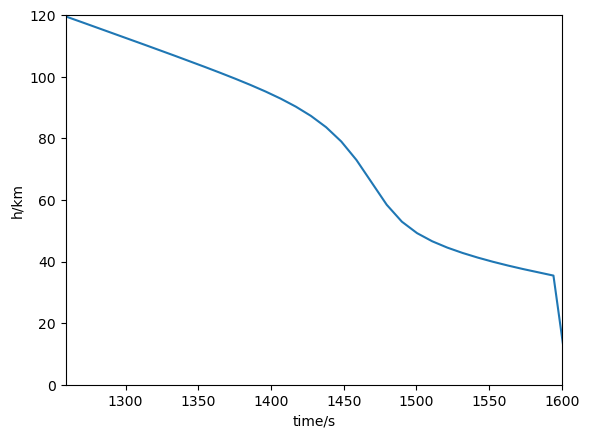

In [5]:
print(f"Final apogee of {orb_fin.r_a-Earth.R}")
print(f"Final perigee of {orb_fin.r_p-Earth.R}")
plt.ylabel("h/km")
# plt.xlabel("distance downrange, km")
plt.xlabel("time/s")
plt.xlim(1259,1600)
plt.ylim(top = 120)
plt.plot(tofs, pos_spherical.distance - Earth.R)

Entry interface at 1263.1648719808834 seconds
Lithobrake event seen at 1600.9730648154737 seconds


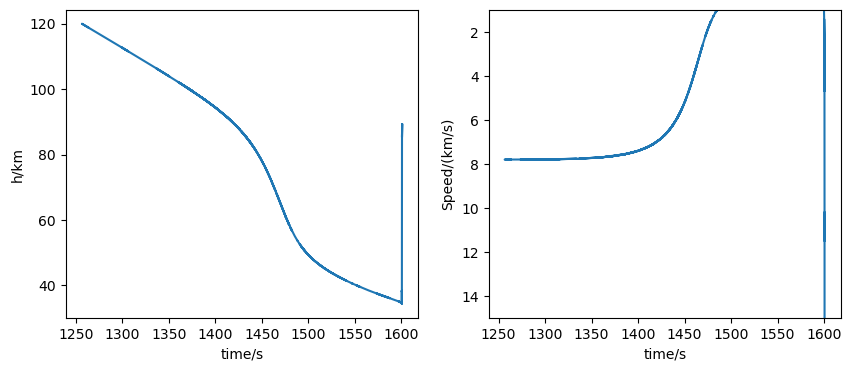

In [6]:

impact_time = 0
if entry_interface >0:
    print(f"Entry interface at {entry_interface} seconds")
if lithobrake_event.last_t.to(u.s)< prop_time:
    impact_time = lithobrake_event.last_t.to(u.s)
    print(f"Lithobrake event seen at {lithobrake_event.last_t.to(u.s).value} seconds")


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))


ax1.set_ylabel("h/km")
# plt.xlabel("distance downrange, km")
ax1.set_xlabel("time/s")
#plt.xlim(12500,14000)
#plt.ylim(top = 100)
#print(reentry_alts)
plt.ylim(150)
ax1.plot(np.array(reentry_time),np.array(reentry_alts))
#drag 0.47813373175961593 hours
#none 0.4863379477979069 hours
#print(np.array(reentry_vel)[15])
plt.ylim(15)
ax2.set_xlabel("time/s")
ax2.set_ylabel("Speed/(km/s)")
ax2.plot(np.array(reentry_time),np.array(reentry_vel))